## Data Loading

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [38]:
gsw = pd.read_excel('data/gsw_yields.xlsx', index_col=0, parse_dates=True)

maturities = [2,5,10]
yields = gsw[maturities].dropna()
yields.columns = ['2Y','5Y','10Y']

yields = yields.loc['2015':]

yields_diff = yields.diff(periods=1).dropna()
yields_diff.tail()


scaler = StandardScaler()
yields_diff_scaled = scaler.fit_transform(yields_diff)

## Question 3: Signal Design and Backtest

**Design a mean-reversion trading strategy on the butterfly spread.**


In [39]:
%store -r weights

# Calculate the butterfly spread
butterfly_spread = weights[0] * yields_diff['2Y'] + weights[1] * yields_diff['5Y'] + weights[2] * yields_diff['10Y']

def mean_reversion(look_back_window, entry_threshold, exit_threshold, spread_data):
    """
    Generate mean reversion trading signals based on z-scores
    
    Parameters:
    - look_back_window: rolling window for mean/std calculation
    - entry_threshold: z-score threshold to enter position
    - exit_threshold: z-score threshold to exit position
    - spread_data: time series of the butterfly spread
    """
    # Calculate rolling mean and std
    rolling_mean = spread_data.rolling(window=look_back_window).mean()
    rolling_std = spread_data.rolling(window=look_back_window).std()
    
    # Calculate z-score
    z_scores = (spread_data - rolling_mean) / rolling_std
    
    # Generate trading signals
    signals = pd.DataFrame(index=spread_data.index)
    signals['Position'] = 0  # 1 for long, -1 for short, 0 for neutral
    signals['Z_Score'] = z_scores
    
    # Entry signals
    signals.loc[z_scores > entry_threshold, 'Position'] = -1  # Short when spread is high
    signals.loc[z_scores < -entry_threshold, 'Position'] = 1   # Long when spread is low
    
    # Exit signals (overwrite entry signals when within exit threshold)
    signals.loc[abs(z_scores) < exit_threshold, 'Position'] = 0
    
    # Forward fill positions (hold position until exit signal)
    signals['Position'] = signals['Position'].replace(0, np.nan).ffill().fillna(0)
    
    return signals, z_scores

def backtest_strategy(signals, spread_data):
    """
    Backtest the mean reversion strategy
    
    Parameters:
    - signals: DataFrame with Position column
    - spread_data: time series of the butterfly spread
    """
    # Calculate daily spread changes (this is your P&L driver)
    daily_changes = spread_data.diff()
    
    # Calculate strategy returns (position from previous day * today's change)
    # Use shift(1) because you enter position based on yesterday's signal
    strategy_returns = signals['Position'].shift(1) * daily_changes
    
    # Calculate cumulative returns
    cumulative_returns = strategy_returns.cumsum()
    
    return strategy_returns, cumulative_returns



a) Construct a z-score signal:
   - Choose a lookback window for the rolling mean and standard deviation (justify your choice—consider the tradeoff between responsiveness and stability)
   - Compute: $z_t = (\text{spread}_t - \mu_t) / \sigma_t$

**Justification:** We use a **20-day lookback window** (approx. 1 trading month). This period balances responsiveness (capturing recent regime changes) with stability (smoothing out daily noise).

In [40]:
look_back_window = 20


b) Define trading rules:
   - Entry: When should you go long curvature? Short curvature?
   - Exit: When should you close the position?
   - Document your threshold choices (e.g., ±1σ, ±1.5σ, ±2σ)

**Trading Rules:**
- **Short Curvature:** Enter when $z > \text{entry}$ (Spread is high, expected to mean-revert down).
- **Long Curvature:** Enter when $z < -\text{entry}$ (Spread is low, expected to mean-revert up).
- **Exit:** Close when $|z| < \text{exit}$.
- **Thresholds:** Entry = 1.5 (significant deviation), Exit = 0.5 (near mean).

In [41]:
entry_threshold = 1.5  # Enter when spread is 1.5 std devs away
exit_threshold = 0.5   # Exit when spread is within 0.5 std devs


c) Backtest the strategy daily:
   - $\text{P\&L}_t = \text{position}_{t-1} \times \Delta\text{spread}_t$
   - Report: cumulative P&L, Sharpe ratio, maximum drawdown, hit rate


In [42]:
signals, z_scores = mean_reversion(look_back_window, entry_threshold, exit_threshold, butterfly_spread)
strategy_returns, cumulative_returns = backtest_strategy(signals, butterfly_spread)


d) Sensitivity analysis: How do results change with different entry thresholds? Present a table comparing at least three threshold choices.

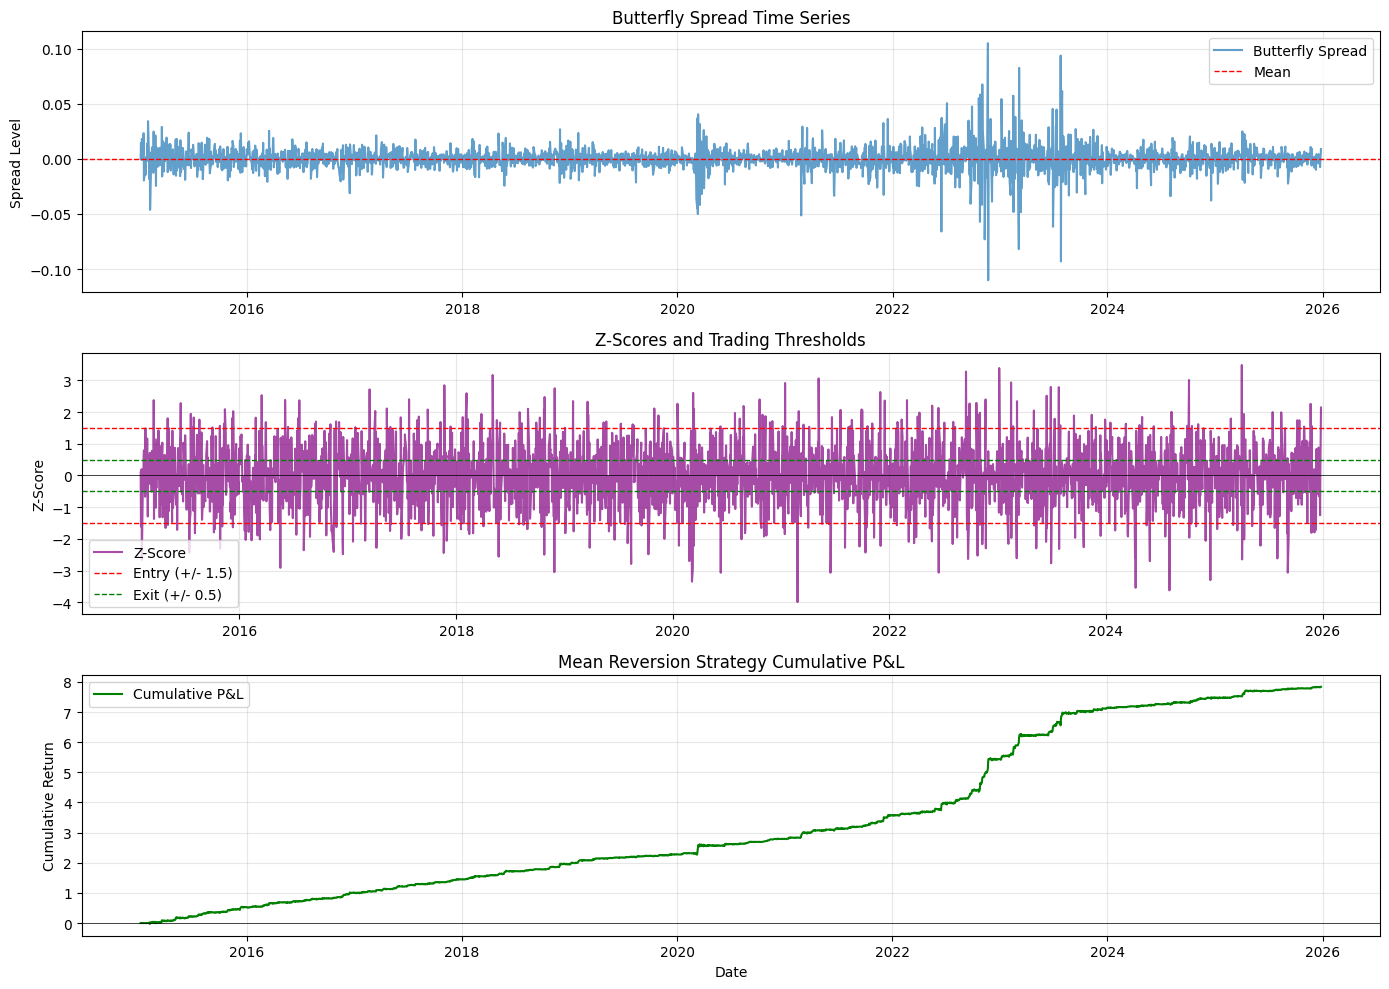


=== Strategy Performance Summary ===
Total Return: 7.8379
Annualized Return: 0.7195
Annualized Volatility: 0.2651
Sharpe Ratio: 2.7141
Max Drawdown: -0.1179
Number of Trades: 190

=== Sensitivity Analysis (Part d) ===


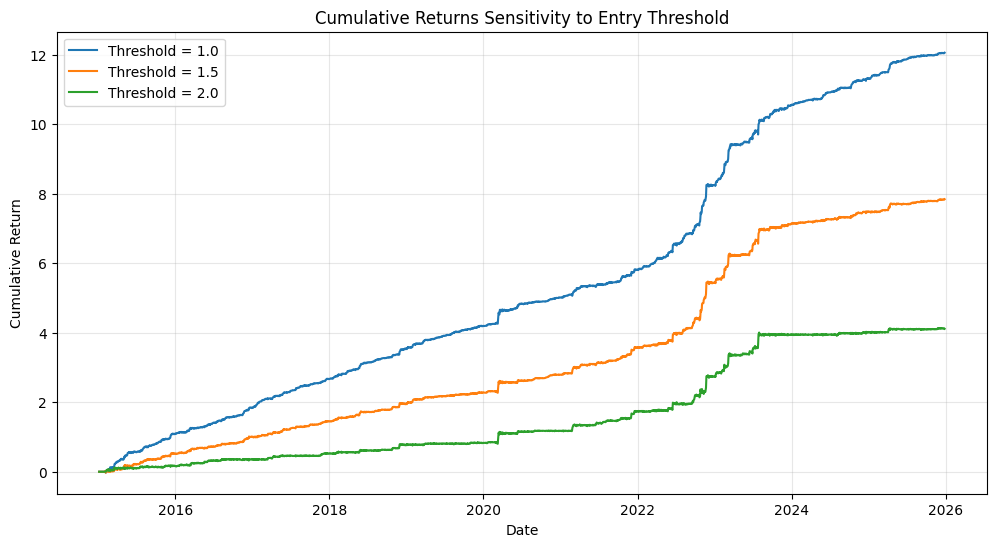

,Entry Threshold,Total Return,Sharpe Ratio,Max Drawdown
0,1.0,12.051647,4.259068,-0.117887
1,1.5,7.837917,2.714116,-0.117887
2,2.0,4.112325,1.411862,-0.140662


In [43]:

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Plot 1: Butterfly Spread
axes[0].plot(butterfly_spread.index, butterfly_spread, label='Butterfly Spread', alpha=0.7)
axes[0].axhline(butterfly_spread.mean(), color='r', linestyle='--', label='Mean', linewidth=1)
axes[0].set_title('Butterfly Spread Time Series')
axes[0].set_ylabel('Spread Level')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Z-Scores and Trading Signals
axes[1].plot(z_scores.index, z_scores, label='Z-Score', color='purple', alpha=0.7)
axes[1].axhline(entry_threshold, color='r', linestyle='--', label=f'Entry (+/- {entry_threshold})', linewidth=1)
axes[1].axhline(-entry_threshold, color='r', linestyle='--', linewidth=1)
axes[1].axhline(exit_threshold, color='g', linestyle='--', label=f'Exit (+/- {exit_threshold})', linewidth=1)
axes[1].axhline(-exit_threshold, color='g', linestyle='--', linewidth=1)
axes[1].axhline(0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_title('Z-Scores and Trading Thresholds')
axes[1].set_ylabel('Z-Score')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Cumulative Returns
axes[2].plot(cumulative_returns.index, cumulative_returns, label='Cumulative P&L', color='green')
axes[2].axhline(0, color='black', linestyle='-', linewidth=0.5)
axes[2].set_title('Mean Reversion Strategy Cumulative P&L')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Cumulative Return')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Strategy Performance Summary ===")
print(f"Total Return: {cumulative_returns.iloc[-1]:.4f}")
print(f"Annualized Return: {strategy_returns.mean() * 252:.4f}")
print(f"Annualized Volatility: {strategy_returns.std() * np.sqrt(252):.4f}")
print(f"Sharpe Ratio: {(strategy_returns.mean() / strategy_returns.std()) * np.sqrt(252):.4f}")
print(f"Max Drawdown: {(cumulative_returns - cumulative_returns.cummax()).min():.4f}")
print(f"Number of Trades: {signals['Position'].diff().abs().sum() / 2:.0f}")

print("\n=== Sensitivity Analysis (Part d) ===")
thresholds = [1.0, 1.5, 2.0]
sensitivity_results = []

plt.figure(figsize=(12, 6))

for entry in thresholds:
    s_sigs, _ = mean_reversion(look_back_window, entry, exit_threshold, butterfly_spread)
    s_ret, c_ret = backtest_strategy(s_sigs, butterfly_spread)
    
    sensitivity_results.append({
        'Entry Threshold': entry,
        'Total Return': c_ret.iloc[-1],
        'Sharpe Ratio': (s_ret.mean() / s_ret.std()) * np.sqrt(252),
        'Max Drawdown': (c_ret - c_ret.cummax()).min()
    })
    
    plt.plot(c_ret.index, c_ret, label=f'Threshold = {entry}')

plt.title('Cumulative Returns Sensitivity to Entry Threshold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

results_df = pd.DataFrame(sensitivity_results)
from IPython.display import display
display(results_df)

The results of the strategy worsen as the entry thresholds increase.